## Objetivo:

 Consolidar los conocimientos adquiridos en clase para los métodos de búsqueda y bases de datos orientadas a grafos.
    
## Enunciado:

    Diseñe y desarrolle un sistema recopilador que permita obtener las noticias o facebook de los candidatos 
    y almacenar dentro de una base de datos orientados a grafos: 
    Webscraping es la técnica de extraer datos contenidos en un formato no estructurado en una página web y 
    llevarlos a una estructura fácil de usar.
    Es por ello, que se desea crear nuevos métodos que permitan la recopilación masiva de informaciones para 
    su posterior estudio y correlación en forma de big data.
    En base a ello, vamos a obtener los datos de lo que esta hablando las noticias de los candidatos dentro d
    el Ecuador y almacenar los datos dentro de una base de datos orientadas a grafos.
    https://www.google.com/search?tbm=nws&sxsrf=ALeKk01Q48xyd7421N_rrjzDN56Mnp8FTg:1607467777701&q=candidatos
            +ecuador&spell=1&sa=X&ved=0ahUKEwioo4KPvL_tAhXFrFkKHXv8CC8QBQgvKAA&biw=1920&bih=915&dpr=1
        ◦ Generar un modelo que permita obtener y almacenar los datos en los grafos.
        ◦ Vincular los datos con el candidato seleccionado.
        ◦ Se debe tener al menos 1000 nodos generados, en caso de tener estos datos seleccionar al partido                (UNES) 
      (UNES AZUAY) (Candidato Presidencial)
        ◦ Obtener de la noticia: el Link, mensaje, fecha
        ◦ Facebook: Comentarios, Publicaciones, Amigos, Likes, Seguidores, etc.
        ◦ No se debe repetir los candidatos a asambleístas dentro del Foro del partido político de UNES AZUAY
        (10 primeros) .
        ◦ Se puede utilizar cualquier herramienta o procesamiento para el WebScarping.
        ◦ Generar sus análisis, conclusiones y recomendaciones en base a  los datos 

    

# funciones principales
Creamos los nodos

In [21]:
from neo4j import GraphDatabase

class Neo4jService(object):

    def __init__(self, uri, user, password):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self._driver.close()      
    
    def crear_cabecera(self, tx, nombre):
        tx.run("CREATE (:Cabecera {nombre: $nombre})", nombre=nombre)
    
    def crear_candidato(self, tx, nombre):
        tx.run("CREATE (:Candidato {nombre: $nombre})", nombre=nombre)

    def crear_noticias(self, tx, nombre):
        tx.run("CREATE (:Noticias {nombre: $nombre})", nombre=nombre)
    
    def crear_links(self, tx, nombre):
        tx.run("CREATE (:Links {nombre: $nombre})", nombre=nombre)
        
    def crear_contenido(self, tx, nombre):
        tx.run("CREATE (:Contenido {nombre: $nombre})", nombre=nombre)
        
    def crear_titulo(self, tx, nombre):
        tx.run("CREATE (:Titulo {nombre: $nombre})", nombre=nombre)

    def crear_fecha(self, tx, nombre):
        tx.run("CREATE (:Fecha {nombre: $nombre})", nombre=nombre)
        
    def crear_relacion_noticia(self, tx, nombre_noticias, nombre_noticia):
        tx.run("MATCH (a:Noticias {nombre: $nombre_noticias}) "
               "MATCH (b:Contenido {nombre: $nombre_noticia}) "
               "MERGE (a)-[:Noticias]->(b)",
               nombre_noticias=nombre_noticias, nombre_noticia=nombre_noticia)
    
    def crear_relacion_cabeceras(self, tx, nombre_cabecera, nombre_titulo):
        tx.run("MATCH (a:Cabecera {nombre: $nombre_cabecera}) "
               "MATCH (b:Titulo {nombre: $nombre_titulo}) "
               "MERGE (a)-[:TituloNoticia]->(b)",
               nombre_cabecera=nombre_cabecera, nombre_titulo=nombre_titulo)
    
    def crear_relacion_fecha(self, tx, nombre_links, nombre_fecha):
        tx.run("MATCH (a:Links {nombre: $nombre_links}) "
               "MATCH (b:Fecha {nombre: $nombre_fecha}) "
               "MERGE (a)-[:Fecha]->(b)",
               nombre_links=nombre_links, nombre_fecha=nombre_fecha)

    #relacion de candidato   cabecera links noticias 
    def crear_relacion_candidato_titulo(self, tx, nombre_candidato, nombre_titulo):
        tx.run("MATCH (a:Candidato {nombre: $nombre_candidato}) "
               "MATCH (b:Cabecera {nombre: $nombre_titulo}) "
               "MERGE (a)-[:Candidato_Titulo]->(b)",
               nombre_candidato=nombre_candidato, nombre_titulo=nombre_titulo)
        
    def crear_relacion_candidato_fecha(self, tx, nombre_candidato, nombre_fecha):
        tx.run("MATCH (a:Candidato {nombre: $nombre_candidato}) "
               "MATCH (b:Links {nombre: $nombre_fecha}) "
               "MERGE (a)-[:Candidato_Fecha]->(b)",
               nombre_candidato=nombre_candidato, nombre_fecha=nombre_fecha)
    
    def crear_relacion_candidato_contenido(self, tx, nombre_candidato, nombre_noticias):
        tx.run("MATCH (a:Candidato {nombre: $nombre_candidato}) "
               "MATCH (b:Noticias {nombre: $nombre_noticias}) "
               "MERGE (a)-[:Candidato_Noticias]->(b)",
               nombre_candidato=nombre_candidato, nombre_noticias=nombre_noticias)
    

# Datos
Usamos lo siguiente para extraer los datos solicitados de los navegadores web

In [ ]:
import requests
from bs4 import BeautifulSoup

neo4j = Neo4jService('bolt://localhost:7687', 'neo4j', 'patito.123')
with neo4j._driver.session() as session:

    session.write_transaction(neo4j.crear_candidato , "Candidato")
    session.write_transaction(neo4j.crear_cabecera , "Titulos")
    session.write_transaction(neo4j.crear_links , "Fecha")
    session.write_transaction(neo4j.crear_noticias , "Noticias")
             
with open("/home/RobertoPacho/Documentos/IA/linksDatos.txt","r") as archivo:
        
    for linea in archivo:

        page = requests.get(linea)
        soup = BeautifulSoup(page.content,'html.parser')
        #print(soup.prettify())
        
        #titulos
        titulos =soup.find_all("div",{"class":"BNeawe vvjwJb AP7Wnd"})
        #Contenido
        contenidohtml =soup.find_all("div",{"class":"BNeawe s3v9rd AP7Wnd"})
        #Fecha
        fecha =soup.find_all("span",{"class":"r0bn4c rQMQod"})
        
        #print(linea)
        a=0
        
        #Titulos
        tituloNeo=list()
        for i in titulos:
            tituloNeo.append(i.text)

        descripcion=list()
        for i in contenidohtml:
            descripcion.append(i.text)
            
        #descripcion filtrada
        descripcionAux=list()    
        for elemento in descripcion:
            if((a%2)==0):
                descripcionAux.append(descripcion[a])
            a=a+1
            

        fechaNeo=list()
        for i in fecha:
            fechaNeo.append(i.text)

        
            
        #print("Titulo")
        for elemento in tituloNeo:
            session.write_transaction(neo4j.crear_titulo , elemento)
            #print(elemento)
             
        #print("descripcion")
        for elemento1 in descripcionAux:
            session.write_transaction(neo4j.crear_contenido , elemento1)
            #print(elemento1)
        
        
        #print("fecha")
        for elemento2 in fechaNeo:
            session.write_transaction(neo4j.crear_fecha , elemento2)
            #print(elemento2)
            

#relaciones
        #relacion de descripcion
        for total in descripcionAux:
            session.write_transaction(neo4j.crear_relacion_noticia, "Noticias", total)  
            
        #relacion de Fecha               
        for date in fechaNeo:
            session.write_transaction(neo4j.crear_relacion_fecha, "Fecha", date)  
        
        #relacion de Titulo  
        for titul in tituloNeo:
            session.write_transaction(neo4j.crear_relacion_cabeceras, "Titulos", titul) 
            
  #Creamos las relaciones          
session.write_transaction(neo4j.crear_relacion_candidato_titulo, "Candidato", "Titulos")
session.write_transaction(neo4j.crear_relacion_candidato_contenido, "Candidato", "Noticias")
session.write_transaction(neo4j.crear_relacion_candidato_fecha, "Candidato", "Fecha")


# Datos generados en Neo4j

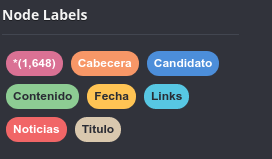

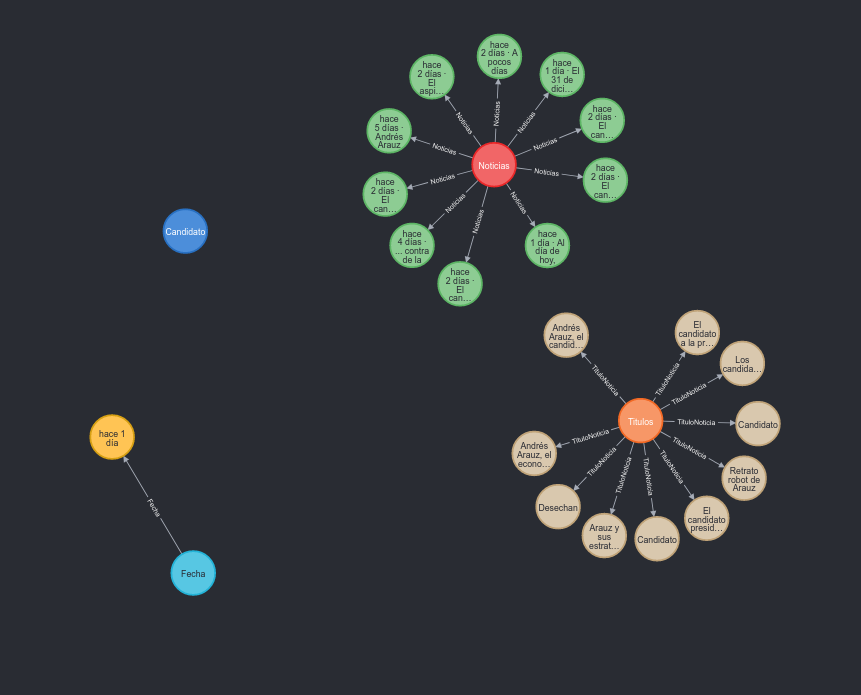